# Example 10: Variational Auto-encoder (VAE)


Variational Auto-encoders (VAE) (Kingma & Welling, 2013; Doersch, 2016) are probably the most influential models 
combining LVMs and DNNs. VAEs extend the classical technique of principal component analysis (PCA) (Jolliffe, 2011) 
for data representation in lower-dimensional spaces.

The pseudo-code blow provides a description of the generative model of a VAE. 

<img src="https://raw.githubusercontent.com/PGM-Lab/ProbModelingDNNs/master/img/nlpca_pseudocode.png" alt="VAE-pseudocode" style="width: 700px;"/>

The present notebook experimentally illustrates the behavior of a VAE as a feature reduction method on (a reduced version of) 
MNIST dataset. The model is implemented using InferPy.


Note that the generative model is identical to the one in a variational auto-encoder, whcih is presented in a separated 
notebook. The difference is that the formulation of VAEs includes an amortized inference function linking the data samples 
with the latent variables $\boldsymbol{z}$. In practice, this will affect to the model defining the Q model.


## Setting up the system

First, we will install and import the required packages as follows.



In [1]:
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import numpy as np
import matplotlib.pyplot as plt
import inferpy as inf
from inferpy.data import mnist
import numpy as np
import pandas as pd
import sys

import warnings
warnings.filterwarnings("ignore")

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Global configuration
num_epochs = 3000
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

## Data 

For illustrating purposes, the MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the ``inferpy`` package (and hence from keras):

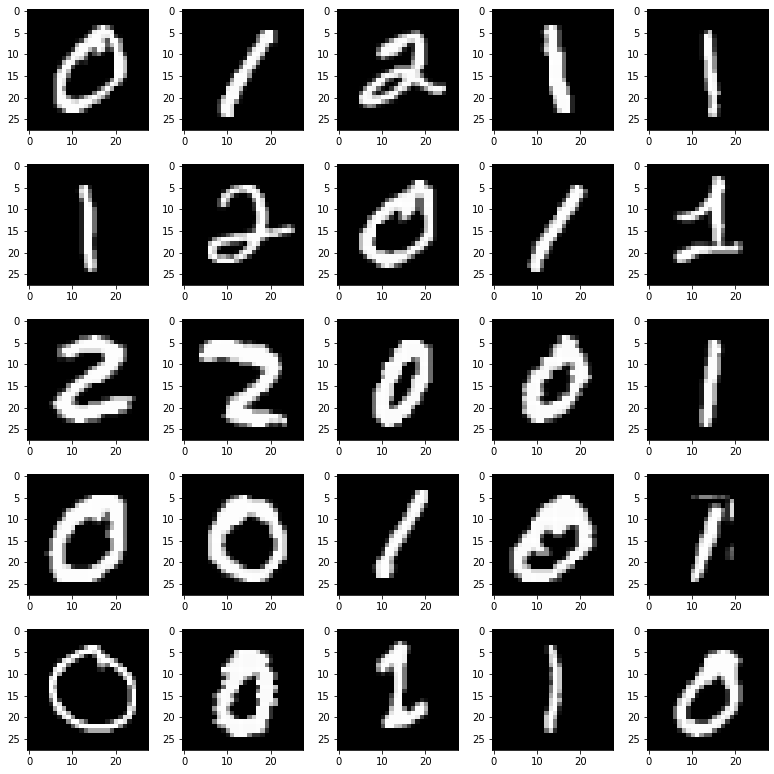

In [2]:
# number of observations (dataset size)
N = 1000
#mini-batch size
M = 100

# digits considered
DIG = [0,1,2]

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot the digits
mnist.plot_digits(x_train, grid=[5,5])

### Model definition

The implementation for the generative model for a VAE model (Algorithm 3) is defined below. The input parameters are: `k` is the latent dimension, `d` is the data-dimension and `N`the number of samples or data instances. 

In [3]:
# Model constants
k, d0, d1 = 2, 100, np.shape(x_train)[-1]

# initial values
loc_init = 0.001
scale_init = 1
scale_epsilon = 0.01

scale_init_encoder = 0.01
scale_epsilon = 0.01

@inf.probmodel
def vae(k, d0, d1, decoder):
    decoder_call = decoder(k, d0, d1)
    with inf.datamodel():
        # Define local latent variables
        z = inf.Normal(loc=tf.ones([k]), scale=1, name="z")
        output = decoder_call(z)
        # Define the observed variables
        x = inf.Normal(loc=output, scale=1., name="x")


def decoder(k, d0, d1):
    beta0 = inf.Normal(tf.zeros([k, d0]), 1., name="beta0")
    alpha0 = inf.Normal(tf.zeros([d0]), 1., name="alpha0")

    beta1 = inf.Normal(tf.zeros([d0, d1]), 1., name="beta1")
    alpha1 = inf.Normal(tf.zeros([d1]), 1., name="alpha1")

    def call(z):
        h0 = tf.nn.relu(z @ beta0 + alpha0, name="h0")
        return h0 @ beta1 + alpha1

    return call

<function vae at 0x7fe9dc4519d8>
<function decoder at 0x7fe9dc451950>


This is a latent varable model (LVM) containing DNNs where the latent representation $\boldsymbol{z}$ is known as the scores, and the affine transformation is performed using a DNN parametrized by $\boldsymbol{\beta}$ and $\boldsymbol{\alpha}$.

### Inference

Variational inference is a deterministic technique that finds a tractable approximation to an intractable (posterior) distribution. 
We will use $q$ to denote the approximation, and use $p$ to signify the true distribution (like $p(\boldsymbol{\beta, \alpha},\boldsymbol{z}|\boldsymbol{x})$ in the example above).
More specifically, ${\cal Q}$ will denote a set of possible approximations $q$.



Usually, we might define a generative model for sampling from $q(\boldsymbol{\beta, \alpha},\boldsymbol{z} | \boldsymbol{\lambda}, \boldsymbol{\phi})$. However, $\boldsymbol{\phi}$ is a parameter vector that grows with the data, $\boldsymbol{\phi} = (\boldsymbol{\phi}_1,\ldots,\boldsymbol{\phi}_N)$, giving rise to an optimization problem which can not be handled when the model involves big data sets. 

Amortized inference solves this problem by learning a mapping function, denoted by $\boldsymbol{s}$, between $\boldsymbol{x}_i$ and $\boldsymbol{\phi}_i$ parameterized by $\boldsymbol{\theta}$. Moreover this mapping will be a neural network, known in the literature as the decoder network.


Therefore we will defined a generative model for sampling from $q(\boldsymbol{\beta, \alpha},\boldsymbol{z} | \boldsymbol{x, \lambda, \theta)}$ as follows.




In [4]:

def encoder(k, d0, d1):
    beta0 = tf.Variable(tf.random_normal([d1, d0], stddev=scale_init), name="encoder_beta0")
    alpha0 = tf.Variable(tf.zeros([d0]), name="encoder_alpha0")

    ######

    beta1 = tf.Variable(tf.random_normal([d0, 2 * k], stddev=scale_init), name="encoder_beta1")
    alpha1 = tf.Variable(tf.zeros([2 * k]), name="encoder_alpha1")
    
    def call(x):
        h0 = tf.nn.relu(x @ beta0 + alpha0, name="encoder_h0")
        return h0 @ beta1 + alpha1
        

    return call

@inf.probmodel
def Q(k, d0, d1, encoder):
    encoder_call = encoder(k, d0, d1)
    
    with inf.datamodel():
        x = inf.Normal(tf.ones([d1])*0.01, 1, name="x")
        output = encoder_call(x)       

        qz_loc = output[:, :k]
        qz_scale = output[:, k:]

        qz = inf.Normal(loc=qz_loc,
                   scale=tf.nn.softplus(qz_scale + tf.math.log(tf.math.expm1(scale_init_encoder))) + scale_epsilon,
                   name="z")
     ###

    qbeta0_loc = inf.Parameter(tf.zeros([k, d0]), name="qbeta0_loc")
    qbeta0_scale = tf.math.softplus(
        inf.Parameter(tf.zeros([k, d0]), name="qbeta0_scale") + tf.math.log(tf.math.expm1(scale_init_encoder)))
    qbeta0 = inf.Normal(qbeta0_loc, qbeta0_scale + scale_epsilon, name="beta0")

    qalpha0_loc = inf.Parameter(tf.zeros([d0]), name="qalpha0_loc")
    qalpha0_scale = tf.math.softplus(
        inf.Parameter(tf.zeros([d0]), name="qalpha0_scale") + tf.math.log(tf.math.expm1(scale_init_encoder)))
    qalpha0 = inf.Normal(qalpha0_loc, qalpha0_scale + scale_epsilon, name="alpha0")

    ###

    qbeta1_loc = inf.Parameter(tf.zeros([d0, d1]), name="qbeta1_loc")
    qbeta1_scale = tf.math.softplus(
        inf.Parameter(tf.zeros([d0, d1]), name="qbeta1_scale") + tf.math.log(tf.math.expm1(scale_init_encoder)))
    qbeta1 = inf.Normal(qbeta1_loc, qbeta1_scale + scale_epsilon, name="beta1")

    qalpha1_loc = inf.Parameter(tf.zeros([d1]), name="qalpha1_loc")
    qalpha1_scale = tf.math.softplus(
        inf.Parameter(tf.zeros([d1]), name="qalpha1_scale") + tf.math.log(tf.math.expm1(scale_init_encoder)))
    qalpha1 = inf.Normal(qalpha1_loc, qalpha1_scale + scale_epsilon, name="alpha1")

<function Q at 0x7fe9dc451ea0>


In [5]:
# create an instance of the P model and the Q model
m = vae(k, d0, d1, decoder)
q = Q(k,d0,d1, encoder)

optimizer = tf.train.AdamOptimizer(learning_rate)
SVI = inf.inference.SVI(q, optimizer=optimizer, epochs=2000)

Finally, the ELBO function is maximized.

In [6]:
# learn the parameters
m.fit({"x": x_train}, SVI)


 0 epochs	 347620999168.0..........
 200 epochs	 1533184384.0..........
 400 epochs	 1518274944.0..........
 600 epochs	 1110127872.0..........
 800 epochs	 957236544.0..........
 1000 epochs	 924299520.0..........
 1200 epochs	 854972608.0..........
 1400 epochs	 833862912.0..........
 1600 epochs	 775000448.0..........
 1800 epochs	 877256000.0..........

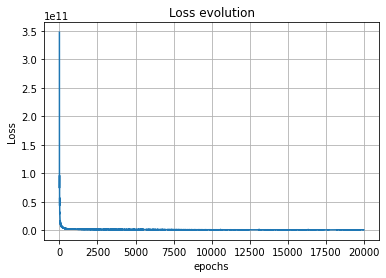

In [7]:
L = SVI.losses
plt.plot(range(len(L)), L)

plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss evolution')
plt.grid(True)
plt.show()

After the inference, we can plot the hidden representation:

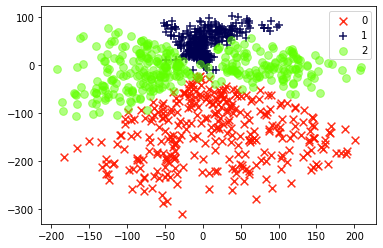

In [13]:
post = {"z": np.concatenate([
    m.posterior("z", data={"x": x_train[i:i+M,:]}).sample()
    for i in range(0,N,M)])}

markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], post["z"][y_train == DIG[c], 1], color=col,
                label=DIG[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()

plt.show()

## Test

For testing our model, we will generate samples of $\boldsymbol{x}$ given the infered posterior distributions.

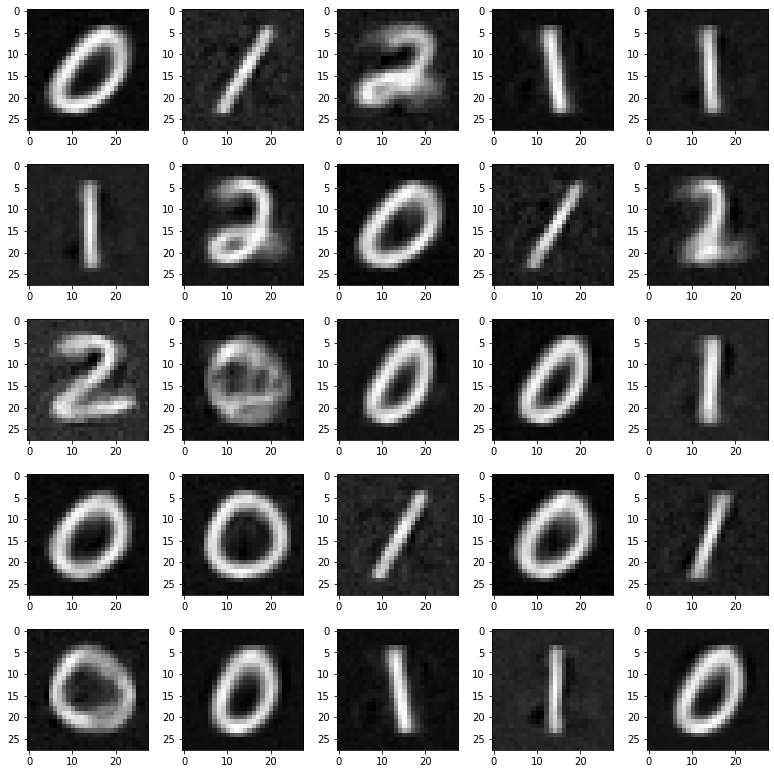

In [9]:
x_gen = m.posterior_predictive('x', data={"z": post["z"][:M,:]}).sample()

# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])